In [1]:
import pandas as pd
import numpy as np
import os
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

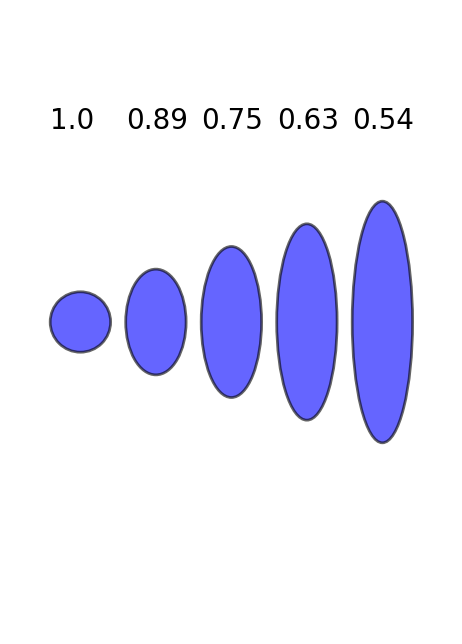

In [2]:
## simulate some ellipses

from matplotlib.patches import Ellipse

num = 5

def calculate_perimeter(a,b):
    perimeter = math.pi * ( 3*(a+b) - math.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

def get_circ(h, w):
    A = math.pi * h * w
    P = calculate_perimeter(h, w)
    circ = 4*math.pi*(A/P**2)
    return circ

x = np.linspace(1, num + 1, num)
y = np.array([5] * num)

xy = np.column_stack((x,y))

height = np.linspace(1, 4, num)
width = np.array([1] * num)

circs = []

for h, w in zip(height, width):
    c = get_circ(h, w)
    circs.append(c)

ells = []
    
for _xy, _h, _w, in zip(xy, height, width):
    e = Ellipse(xy=_xy, width=_w, height=_h) 
    ells.append(e)
    
            
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4
fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.6)
    e.set_facecolor('b')
    e.set_edgecolor('k')

ax.set_xlim(0, num+2)
ax.set_ylim(0, 10)

for _xy, c in zip(xy, circs):
    
    _x = _xy[0] - 0.5
    _y = _xy[1] + 3.2
    plt.text(_x, _y , str(round(c, 2)))

plt.axis("off")
    
plt.show()



In [3]:
root_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/6A/subset_outputs/"

experiments = {
    "B3" : "PRRX1",
    "B5" : "Control",
    "D5" : "MyoD",
    "C2" : "Twist2"
}

df_list = []

for _dir, condition in experiments.items():
    file_path  =f"{root_dir}{_dir}/Cell Count Summary Blue.csv"
    tmp = pd.read_csv(file_path)
    
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Frame'] = tmp.index + 1
    tmp['Delta'] = tmp['Count'].diff()
    
    monotonic_growth = []
    
    count = 0
    for c in tmp['Count']:
        if c > count:
            count = c
        monotonic_growth.append(count)
        
    tmp['Monotonic Growth'] = monotonic_growth
    
    df_list.append(tmp)
    
df = pd.concat(df_list, ignore_index=True)
df.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,Major,Minor,Angle,Scene,Condition,Frame,Delta,Monotonic Growth
0,c:2/4 t:1/102 - B3_subset.czi #1,221,51128.843,231.352,5.014,255,20.993,13.557,98.269,B3,PRRX1,1,NaN,221
1,c:2/4 t:2/102 - B3_subset.czi #1,212,49767.952,234.754,4.881,255,21.309,13.596,97.451,B3,PRRX1,2,-9.0,221
2,c:2/4 t:3/102 - B3_subset.czi #1,225,51305.840,228.026,5.031,255,21.038,13.382,97.196,B3,PRRX1,3,13.0,225
3,c:2/4 t:4/102 - B3_subset.czi #1,225,52519.412,233.420,5.150,255,21.341,13.471,93.436,B3,PRRX1,4,0.0,225
4,c:2/4 t:5/102 - B3_subset.czi #1,224,51578.488,230.261,5.058,255,21.094,13.449,91.697,B3,PRRX1,5,-1.0,225


In [4]:
# normalize the growth by the initial value
df['init_count'] = df.groupby('Condition')['Count'].transform('first')
df['Normalized Count'] =  (df['Count'] / df['init_count']) - 1

# normalize monotonic_growth by the initial value
df['init_count_mono'] = df.groupby('Condition')['Monotonic Growth'].transform(np.min)
df['Normalized Monotonic Count'] =  (df['Monotonic Growth'] / df['init_count_mono']) - 1

# normalize the Delta by the average
df['mean_delta'] = df.groupby('Condition')['Delta'].transform(np.mean)
df['Normalized Delta'] =  df['Delta'] / df['mean_delta']

# add "time" column
df['Time'] = (df['Frame'] * 25) / 60

df.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,Major,Minor,Angle,Scene,...,Frame,Delta,Monotonic Growth,init_count,Normalized Count,init_count_mono,Normalized Monotonic Count,mean_delta,Normalized Delta,Time
0,c:2/4 t:1/102 - B3_subset.czi #1,221,51128.843,231.352,5.014,255,20.993,13.557,98.269,B3,...,1,NaN,221,221,0.000000,221,0.0000,0.574257,NaN,0.416667
1,c:2/4 t:2/102 - B3_subset.czi #1,212,49767.952,234.754,4.881,255,21.309,13.596,97.451,B3,...,2,-9.0,221,221,-0.040724,221,0.0000,0.574257,-15.672414,0.833333
2,c:2/4 t:3/102 - B3_subset.czi #1,225,51305.840,228.026,5.031,255,21.038,13.382,97.196,B3,...,3,13.0,225,221,0.018100,221,0.0181,0.574257,22.637931,1.250000
3,c:2/4 t:4/102 - B3_subset.czi #1,225,52519.412,233.420,5.150,255,21.341,13.471,93.436,B3,...,4,0.0,225,221,0.018100,221,0.0181,0.574257,0.000000,1.666667
4,c:2/4 t:5/102 - B3_subset.czi #1,224,51578.488,230.261,5.058,255,21.094,13.449,91.697,B3,...,5,-1.0,225,221,0.013575,221,0.0181,0.574257,-1.741379,2.083333


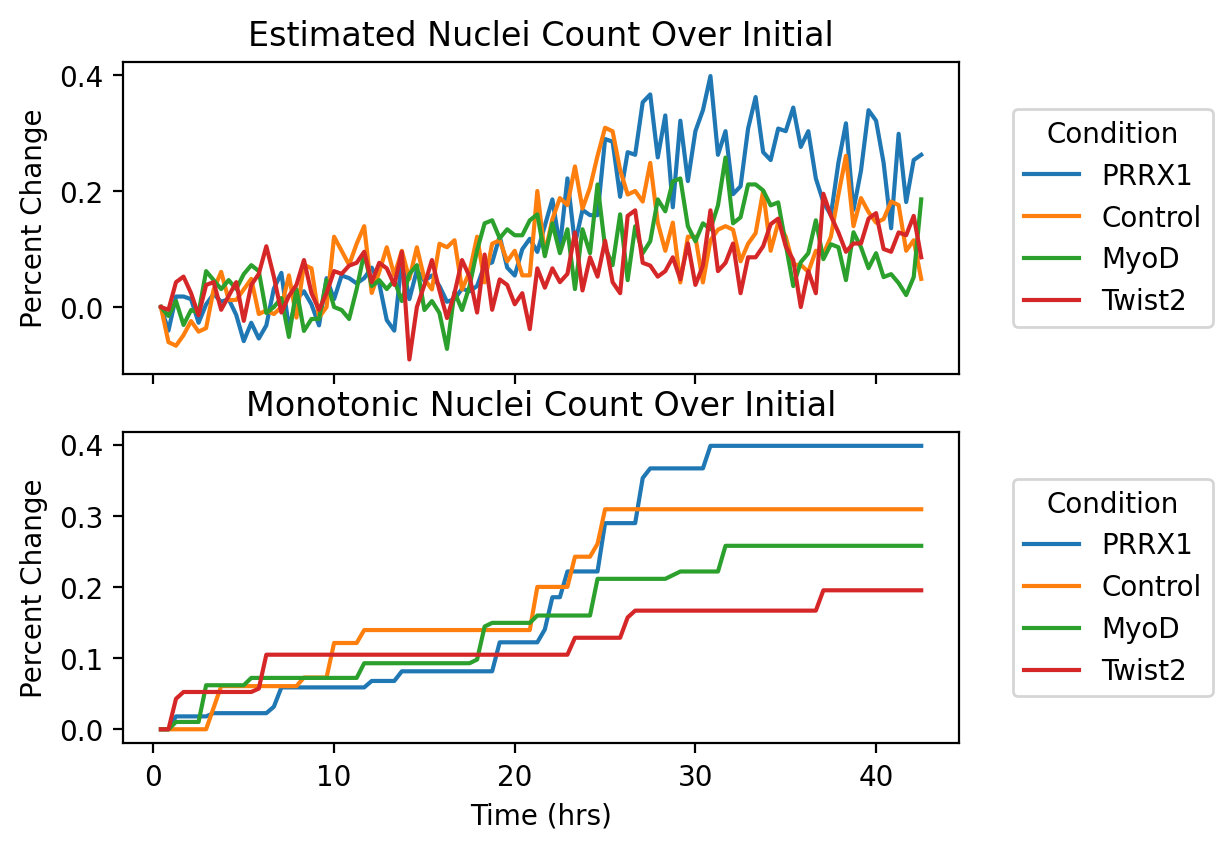

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

fig, axs = plt.subplots(2, sharex=True)
fig.tight_layout()
sns.lineplot(data=df,
             x='Time',
             y='Normalized Count',
             hue='Condition',
             ax=axs[0])

axs[0].set_title("Estimated Nuclei Count Over Initial")
axs[0].set_ylabel("Percent Change")
axs[0].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

sns.lineplot(data=df,
             x='Time',
             y='Normalized Monotonic Count',
             hue='Condition',
             ls='-',
             ax=axs[1])

axs[1].set_title("Monotonic Nuclei Count Over Initial")
axs[1].set_ylabel("Percent Change")
axs[1].set_xlabel("Time (hrs)")
axs[1].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

In [6]:
res = df.groupby('Condition', as_index=False).agg(
    Initial = ('Count', np.min),
    Final = ('Count', np.max),
    MeanChange = ('mean_delta', 'first')
)

res['PercChange'] = (res['Final'] / res['Initial']) - 1

res.columns = [
    'Condition',
    'Inital Nuclei Count',
    'Final Nuclei Count',
    'Mean Nuclei Change (25m)',
    'Percent Change (48hr)',
]

print(res.round(2).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Condition &  Inital Nuclei Count &  Final Nuclei Count &  Mean Nuclei Change (25m) &  Percent Change (48hr) \\
\midrule
  Control &                  154 &                 216 &                      0.08 &                   0.40 \\
     MyoD &                  180 &                 244 &                      0.36 &                   0.36 \\
    PRRX1 &                  208 &                 309 &                      0.57 &                   0.49 \\
   Twist2 &                  191 &                 251 &                      0.18 &                   0.31 \\
\bottomrule
\end{tabular}



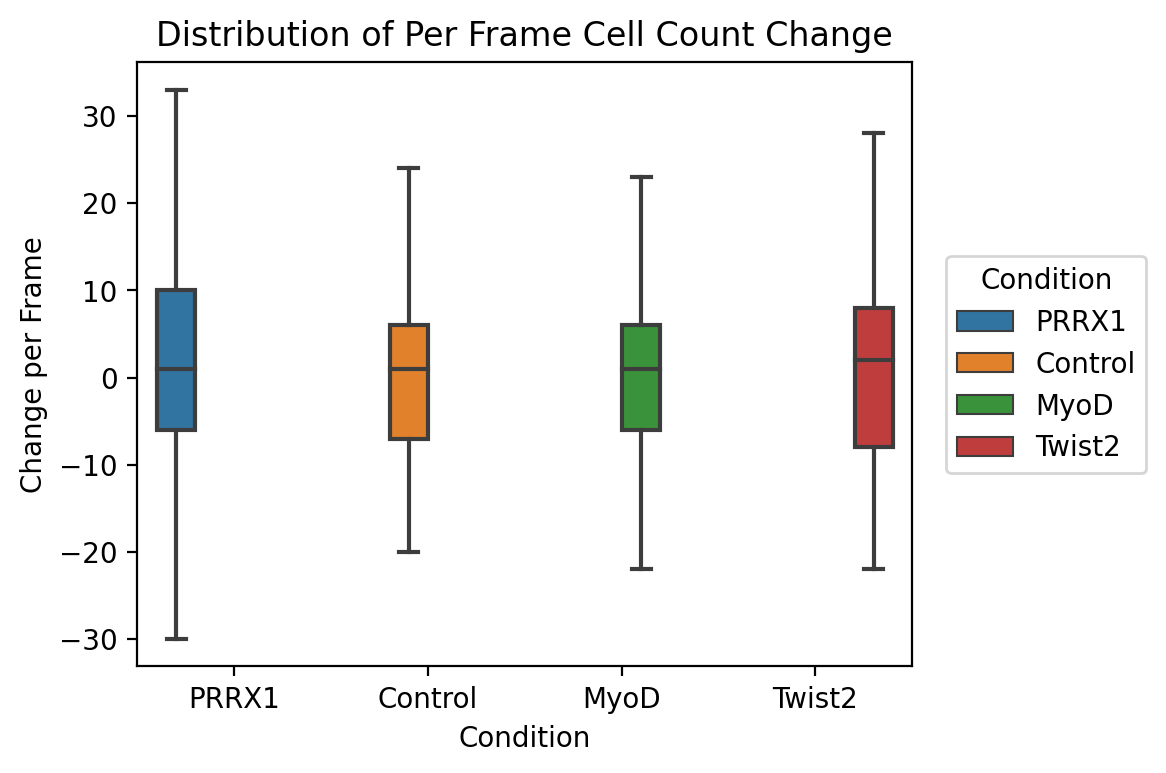

In [7]:
sns.boxplot(data=df,
            x='Condition',
            y='Delta',
            hue='Condition',
            showfliers=False)

plt.title("Distribution of Per Frame Cell Count Change")
plt.ylabel("Change per Frame")
plt.xlabel("Condition")
plt.legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

In [8]:
root_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/6A/subset_outputs/"

experiments = {
    "B3" : "PRAX1",
    "B5" : "Control",
    "D5" : "MyoD",
    "C2" : "Twist2"
}

df_list = []

for _dir, condition in experiments.items():
    file_path = f"{root_dir}{_dir}/Cell Count Summary Red.csv"
    tmp = pd.read_csv(file_path)
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Frame'] = tmp.index + 1
    tmp['Delta'] = tmp['Count'].diff()
    tmp['Channel'] = 'mCherry'
    tmp['init_count'] = tmp['Count'].min()
    tmp['Normalized Count'] = (tmp['Count'] / tmp['init_count']) - 1
    tmp['mean_delta'] = tmp['Delta'].mean()
    tmp['Normalized Delta'] =  tmp['Delta'] / tmp['mean_delta']
    tmp['Time'] = (tmp['Frame'] * 25) / 60
    df_list.append(tmp)
    
    file_path = f"{root_dir}{_dir}/Cell Count Summary Green.csv"
    tmp = pd.read_csv(file_path)
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Frame'] = tmp.index + 1
    tmp['Delta'] = tmp['Count'].diff()
    tmp['Channel'] = 'mVenus'
    tmp['init_count'] = tmp['Count'].min()
    tmp['Normalized Count'] = (tmp['Count'] / tmp['init_count']) - 1
    tmp['mean_delta'] = tmp['Delta'].mean()
    tmp['Normalized Delta'] =  tmp['Delta'] / tmp['mean_delta']
    tmp['Time'] = (tmp['Frame'] * 25) / 60
    df_list.append(tmp)
    
    
df = pd.concat(df_list, ignore_index=True)

df.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,Major,Minor,Angle,Scene,Condition,Frame,Delta,Channel,init_count,Normalized Count,mean_delta,Normalized Delta,Time
0,c:3/4 t:1/102 - B3_subset.czi #1,9,1295.985,143.998,0.127,255,17.618,9.978,103.302,B3,PRAX1,1,NaN,mCherry,9,0.000000,0.168317,NaN,0.416667
1,c:3/4 t:2/102 - B3_subset.czi #1,11,1440.529,130.957,0.141,255,15.872,10.128,106.360,B3,PRAX1,2,2.0,mCherry,9,0.222222,0.168317,11.882353,0.833333
2,c:3/4 t:3/102 - B3_subset.czi #1,11,1299.187,118.108,0.127,255,15.056,9.796,91.556,B3,PRAX1,3,0.0,mCherry,9,0.222222,0.168317,0.000000,1.250000
3,c:3/4 t:4/102 - B3_subset.czi #1,11,1550.485,140.953,0.152,255,15.758,10.801,69.983,B3,PRAX1,4,0.0,mCherry,9,0.222222,0.168317,0.000000,1.666667
4,c:3/4 t:5/102 - B3_subset.czi #1,14,1561.587,111.542,0.153,255,14.251,9.691,84.903,B3,PRAX1,5,3.0,mCherry,9,0.555556,0.168317,17.823529,2.083333


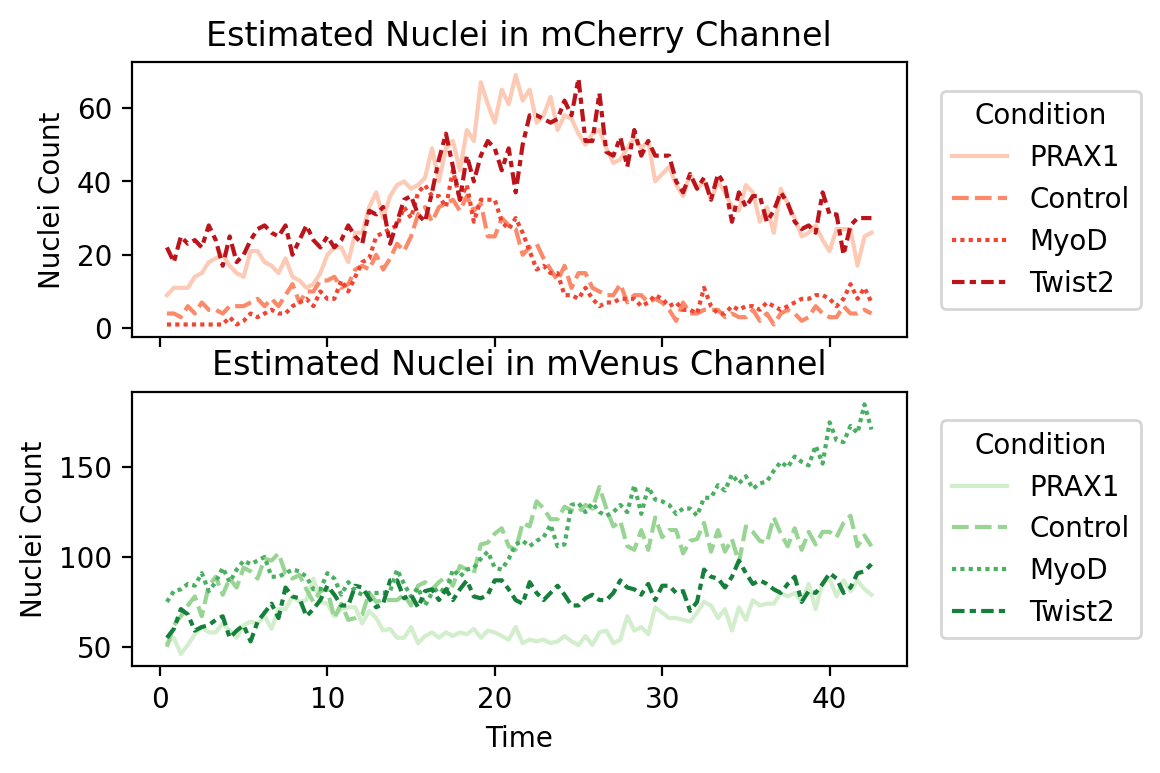

In [9]:
mCher = df[df['Channel'] == 'mCherry']
mVen = df[df['Channel'] == 'mVenus']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

fig, axs = plt.subplots(2, sharex=True)

sns.lineplot(data=mCher,
             x='Time',
             y='Count',
             style='Condition',
             hue='Condition',
             palette='Reds',
             ax=axs[0])

axs[0].set_title("Estimated Nuclei in mCherry Channel")
axs[0].set_ylabel("Nuclei Count")
axs[0].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

sns.lineplot(data=mVen,
             x='Time',
             y='Count',
             style='Condition',
             hue='Condition',
             palette='Greens',
             ax=axs[1])

axs[1].set_title("Estimated Nuclei in mVenus Channel")
axs[1].set_ylabel("Nuclei Count")
axs[1].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)